# Training Pre-trained SSD Model on GEE Dataset

## Imports

In [9]:
import os
os.chdir('/home/jupyter/ee_tree_counting/Models/RetinaNet')

In [10]:
from config import (
    DEVICE,
    NUM_CLASSES,
    NUM_EPOCHS,
    OUT_DIR,
    VISUALIZE_TRANSFORMED_IMAGES,
    NUM_WORKERS,
    RESIZE_TO,
    CLASSES,
)
from RetinaNet import create_model
from custom_utils import (
    Averager,
    SaveBestModel,
    save_model,
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm
from Datasets import (
    CustomDataset,
    create_train_dataset,
    create_valid_dataset,
    create_train_loader,
    create_valid_loader
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import torch
import matplotlib.pyplot as plt
import time
import os
import csv

from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm

plt.style.use('ggplot')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Loading Pre-trained Model

In [11]:
# Update the paths to point to your geospatial dataset
TRAIN_DIR = "/home/jupyter/ee_tree_counting/Data/GEE Dataset/Dataset XML/train"
VALID_DIR = "/home/jupyter/ee_tree_counting/Data/GEE Dataset/Dataset XML/valid"

# Path to the pre-trained model weights
PRETRAINED_WEIGHTS_PATH = "/home/jupyter/ee_tree_counting/Models/RetinaNet/outputs/RetinaNet pretrained tree model/best_model.pth"

NUM_EPOCH = 100

## Model Preview

In [ ]:
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load(PRETRAINED_WEIGHTS_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
# model.to(DEVICE).eval()
model.to(DEVICE).train()

## Train and Validate Functions

In [12]:
# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value


In [13]:
# Function for running validation iterations.
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()
    
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary



## Dataloader and Optimiser

In [13]:
train_dataset = create_train_dataset(TRAIN_DIR)
valid_dataset = create_valid_dataset(VALID_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")


# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
scheduler = StepLR(
    optimizer=optimizer, step_size=15, gamma=0.1, verbose=True
)

Number of training samples: 49
Number of validation samples: 15

36,352,630 total parameters.
36,352,630 training parameters.
Adjusting learning rate of group 0 to 1.0000e-03.



EPOCH 1 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #1 train loss: 1.086
Epoch #1 mAP@0.5: 53.93%
Epoch #1 mAP@0.5:0.95: 21.46%
Took 0.208 minutes for epoch 0

BEST VALIDATION mAP: 0.21456171572208405

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 2 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #2 train loss: 0.614
Epoch #2 mAP@0.5: 65.31%
Epoch #2 mAP@0.5:0.95: 27.13%
Took 0.209 minutes for epoch 1

BEST VALIDATION mAP: 0.2712678611278534

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 3 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #3 train loss: 0.544
Epoch #3 mAP@0.5: 70.73%
Epoch #3 mAP@0.5:0.95: 30.07%
Took 0.216 minutes for epoch 2

BEST VALIDATION mAP: 0.3007453680038452

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 4 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #4 train loss: 0.509
Epoch #4 mAP@0.5: 75.50%
Epoch #4 mAP@0.5:0.95: 32.93%
Took 0.213 minutes for epoch 3

BEST VALIDATION mAP: 0.3293146789073944

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 5 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #5 train loss: 0.463
Epoch #5 mAP@0.5: 74.86%
Epoch #5 mAP@0.5:0.95: 33.90%
Took 0.214 minutes for epoch 4

BEST VALIDATION mAP: 0.3389562964439392

SAVING BEST MODEL FOR EPOCH: 5

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 6 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #6 train loss: 0.446
Epoch #6 mAP@0.5: 77.00%
Epoch #6 mAP@0.5:0.95: 36.04%
Took 0.211 minutes for epoch 5

BEST VALIDATION mAP: 0.3603716790676117

SAVING BEST MODEL FOR EPOCH: 6

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 7 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #7 train loss: 0.424
Epoch #7 mAP@0.5: 78.30%
Epoch #7 mAP@0.5:0.95: 35.90%
Took 0.211 minutes for epoch 6
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 8 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #8 train loss: 0.408
Epoch #8 mAP@0.5: 82.52%
Epoch #8 mAP@0.5:0.95: 38.89%
Took 0.214 minutes for epoch 7

BEST VALIDATION mAP: 0.3889366090297699

SAVING BEST MODEL FOR EPOCH: 8

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 9 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #9 train loss: 0.400
Epoch #9 mAP@0.5: 81.10%
Epoch #9 mAP@0.5:0.95: 38.90%
Took 0.214 minutes for epoch 8

BEST VALIDATION mAP: 0.38903120160102844

SAVING BEST MODEL FOR EPOCH: 9

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 10 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #10 train loss: 0.379
Epoch #10 mAP@0.5: 81.72%
Epoch #10 mAP@0.5:0.95: 38.80%
Took 0.212 minutes for epoch 9
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 11 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #11 train loss: 0.366
Epoch #11 mAP@0.5: 82.71%
Epoch #11 mAP@0.5:0.95: 40.52%
Took 0.212 minutes for epoch 10

BEST VALIDATION mAP: 0.40517815947532654

SAVING BEST MODEL FOR EPOCH: 11

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 12 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #12 train loss: 0.358
Epoch #12 mAP@0.5: 81.93%
Epoch #12 mAP@0.5:0.95: 40.43%
Took 0.212 minutes for epoch 11
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 13 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #13 train loss: 0.350
Epoch #13 mAP@0.5: 83.74%
Epoch #13 mAP@0.5:0.95: 41.40%
Took 0.213 minutes for epoch 12

BEST VALIDATION mAP: 0.4140017330646515

SAVING BEST MODEL FOR EPOCH: 13

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 14 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #14 train loss: 0.331
Epoch #14 mAP@0.5: 83.45%
Epoch #14 mAP@0.5:0.95: 40.73%
Took 0.213 minutes for epoch 13
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-03.

EPOCH 15 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #15 train loss: 0.325
Epoch #15 mAP@0.5: 85.24%
Epoch #15 mAP@0.5:0.95: 42.69%
Took 0.213 minutes for epoch 14

BEST VALIDATION mAP: 0.4269355535507202

SAVING BEST MODEL FOR EPOCH: 15

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 16 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #16 train loss: 0.315
Epoch #16 mAP@0.5: 84.21%
Epoch #16 mAP@0.5:0.95: 41.71%
Took 0.212 minutes for epoch 15
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 17 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #17 train loss: 0.313
Epoch #17 mAP@0.5: 83.90%
Epoch #17 mAP@0.5:0.95: 41.89%
Took 0.212 minutes for epoch 16
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 18 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #18 train loss: 0.306
Epoch #18 mAP@0.5: 84.36%
Epoch #18 mAP@0.5:0.95: 42.78%
Took 0.214 minutes for epoch 17

BEST VALIDATION mAP: 0.4277579188346863

SAVING BEST MODEL FOR EPOCH: 18

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 19 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #19 train loss: 0.306
Epoch #19 mAP@0.5: 84.65%
Epoch #19 mAP@0.5:0.95: 42.67%
Took 0.212 minutes for epoch 18
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 20 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #20 train loss: 0.309
Epoch #20 mAP@0.5: 84.89%
Epoch #20 mAP@0.5:0.95: 42.14%
Took 0.214 minutes for epoch 19
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 21 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #21 train loss: 0.301
Epoch #21 mAP@0.5: 84.53%
Epoch #21 mAP@0.5:0.95: 42.14%
Took 0.213 minutes for epoch 20
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 22 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #22 train loss: 0.297
Epoch #22 mAP@0.5: 84.29%
Epoch #22 mAP@0.5:0.95: 42.04%
Took 0.212 minutes for epoch 21
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 23 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #23 train loss: 0.301
Epoch #23 mAP@0.5: 84.43%
Epoch #23 mAP@0.5:0.95: 42.21%
Took 0.212 minutes for epoch 22
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 24 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #24 train loss: 0.303
Epoch #24 mAP@0.5: 85.13%
Epoch #24 mAP@0.5:0.95: 42.82%
Took 0.213 minutes for epoch 23

BEST VALIDATION mAP: 0.42823484539985657

SAVING BEST MODEL FOR EPOCH: 24

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 25 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #25 train loss: 0.304
Epoch #25 mAP@0.5: 84.54%
Epoch #25 mAP@0.5:0.95: 42.50%
Took 0.213 minutes for epoch 24
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 26 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #26 train loss: 0.307
Epoch #26 mAP@0.5: 84.48%
Epoch #26 mAP@0.5:0.95: 42.45%
Took 0.213 minutes for epoch 25
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 27 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #27 train loss: 0.305
Epoch #27 mAP@0.5: 84.47%
Epoch #27 mAP@0.5:0.95: 42.54%
Took 0.213 minutes for epoch 26
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 28 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #28 train loss: 0.303
Epoch #28 mAP@0.5: 84.87%
Epoch #28 mAP@0.5:0.95: 41.99%
Took 0.213 minutes for epoch 27
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 29 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #29 train loss: 0.300
Epoch #29 mAP@0.5: 85.62%
Epoch #29 mAP@0.5:0.95: 42.02%
Took 0.213 minutes for epoch 28
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 30 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #30 train loss: 0.299
Epoch #30 mAP@0.5: 85.22%
Epoch #30 mAP@0.5:0.95: 42.58%
Took 0.214 minutes for epoch 29
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 31 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #31 train loss: 0.302
Epoch #31 mAP@0.5: 84.85%
Epoch #31 mAP@0.5:0.95: 42.31%
Took 0.212 minutes for epoch 30
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 32 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #32 train loss: 0.289
Epoch #32 mAP@0.5: 84.73%
Epoch #32 mAP@0.5:0.95: 42.21%
Took 0.213 minutes for epoch 31
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 33 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #33 train loss: 0.292
Epoch #33 mAP@0.5: 84.52%
Epoch #33 mAP@0.5:0.95: 42.00%
Took 0.213 minutes for epoch 32
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 34 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #34 train loss: 0.299
Epoch #34 mAP@0.5: 84.49%
Epoch #34 mAP@0.5:0.95: 42.20%
Took 0.213 minutes for epoch 33
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 35 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #35 train loss: 0.304
Epoch #35 mAP@0.5: 85.31%
Epoch #35 mAP@0.5:0.95: 42.33%
Took 0.218 minutes for epoch 34
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 36 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #36 train loss: 0.299
Epoch #36 mAP@0.5: 84.72%
Epoch #36 mAP@0.5:0.95: 42.18%
Took 0.213 minutes for epoch 35
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 37 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #37 train loss: 0.300
Epoch #37 mAP@0.5: 84.31%
Epoch #37 mAP@0.5:0.95: 42.07%
Took 0.213 minutes for epoch 36
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 38 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #38 train loss: 0.301
Epoch #38 mAP@0.5: 85.17%
Epoch #38 mAP@0.5:0.95: 42.49%
Took 0.211 minutes for epoch 37
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 39 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #39 train loss: 0.295
Epoch #39 mAP@0.5: 84.04%
Epoch #39 mAP@0.5:0.95: 42.26%
Took 0.213 minutes for epoch 38
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 40 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #40 train loss: 0.302
Epoch #40 mAP@0.5: 84.32%
Epoch #40 mAP@0.5:0.95: 41.88%
Took 0.213 minutes for epoch 39
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 41 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #41 train loss: 0.294
Epoch #41 mAP@0.5: 85.17%
Epoch #41 mAP@0.5:0.95: 42.81%
Took 0.212 minutes for epoch 40
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 42 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #42 train loss: 0.295
Epoch #42 mAP@0.5: 84.61%
Epoch #42 mAP@0.5:0.95: 42.25%
Took 0.212 minutes for epoch 41
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 43 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #43 train loss: 0.300
Epoch #43 mAP@0.5: 85.15%
Epoch #43 mAP@0.5:0.95: 42.67%
Took 0.212 minutes for epoch 42
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 44 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #44 train loss: 0.296
Epoch #44 mAP@0.5: 85.03%
Epoch #44 mAP@0.5:0.95: 42.39%
Took 0.213 minutes for epoch 43
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 45 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #45 train loss: 0.294
Epoch #45 mAP@0.5: 84.62%
Epoch #45 mAP@0.5:0.95: 42.33%
Took 0.213 minutes for epoch 44
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 46 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #46 train loss: 0.292
Epoch #46 mAP@0.5: 84.90%
Epoch #46 mAP@0.5:0.95: 42.39%
Took 0.212 minutes for epoch 45
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 47 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #47 train loss: 0.293
Epoch #47 mAP@0.5: 85.21%
Epoch #47 mAP@0.5:0.95: 42.57%
Took 0.211 minutes for epoch 46
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 48 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #48 train loss: 0.297
Epoch #48 mAP@0.5: 84.66%
Epoch #48 mAP@0.5:0.95: 42.17%
Took 0.212 minutes for epoch 47
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 49 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #49 train loss: 0.296
Epoch #49 mAP@0.5: 84.90%
Epoch #49 mAP@0.5:0.95: 42.63%
Took 0.214 minutes for epoch 48
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 50 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #50 train loss: 0.294
Epoch #50 mAP@0.5: 84.92%
Epoch #50 mAP@0.5:0.95: 42.45%
Took 0.212 minutes for epoch 49
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 51 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #51 train loss: 0.293
Epoch #51 mAP@0.5: 84.72%
Epoch #51 mAP@0.5:0.95: 42.12%
Took 0.213 minutes for epoch 50
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 52 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #52 train loss: 0.294
Epoch #52 mAP@0.5: 84.26%
Epoch #52 mAP@0.5:0.95: 42.11%
Took 0.211 minutes for epoch 51
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 53 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #53 train loss: 0.294
Epoch #53 mAP@0.5: 84.79%
Epoch #53 mAP@0.5:0.95: 42.63%
Took 0.213 minutes for epoch 52
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 54 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #54 train loss: 0.295
Epoch #54 mAP@0.5: 84.56%
Epoch #54 mAP@0.5:0.95: 42.27%
Took 0.213 minutes for epoch 53
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 55 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #55 train loss: 0.293
Epoch #55 mAP@0.5: 84.70%
Epoch #55 mAP@0.5:0.95: 42.79%
Took 0.214 minutes for epoch 54
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 56 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #56 train loss: 0.299
Epoch #56 mAP@0.5: 84.36%
Epoch #56 mAP@0.5:0.95: 42.50%
Took 0.214 minutes for epoch 55
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 57 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #57 train loss: 0.301
Epoch #57 mAP@0.5: 84.86%
Epoch #57 mAP@0.5:0.95: 42.77%
Took 0.225 minutes for epoch 56
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 58 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #58 train loss: 0.301
Epoch #58 mAP@0.5: 84.84%
Epoch #58 mAP@0.5:0.95: 42.24%
Took 0.213 minutes for epoch 57
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 59 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #59 train loss: 0.292
Epoch #59 mAP@0.5: 84.82%
Epoch #59 mAP@0.5:0.95: 42.74%
Took 0.214 minutes for epoch 58
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 60 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #60 train loss: 0.310
Epoch #60 mAP@0.5: 84.75%
Epoch #60 mAP@0.5:0.95: 42.21%
Took 0.214 minutes for epoch 59
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 61 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #61 train loss: 0.296
Epoch #61 mAP@0.5: 85.14%
Epoch #61 mAP@0.5:0.95: 42.99%
Took 0.212 minutes for epoch 60

BEST VALIDATION mAP: 0.4298935532569885

SAVING BEST MODEL FOR EPOCH: 61

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 62 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #62 train loss: 0.297
Epoch #62 mAP@0.5: 84.74%
Epoch #62 mAP@0.5:0.95: 42.55%
Took 0.211 minutes for epoch 61
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 63 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #63 train loss: 0.299
Epoch #63 mAP@0.5: 84.88%
Epoch #63 mAP@0.5:0.95: 42.24%
Took 0.215 minutes for epoch 62
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 64 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #64 train loss: 0.303
Epoch #64 mAP@0.5: 84.37%
Epoch #64 mAP@0.5:0.95: 42.51%
Took 0.212 minutes for epoch 63
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 65 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #65 train loss: 0.293
Epoch #65 mAP@0.5: 84.89%
Epoch #65 mAP@0.5:0.95: 42.18%
Took 0.211 minutes for epoch 64
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 66 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #66 train loss: 0.292
Epoch #66 mAP@0.5: 84.73%
Epoch #66 mAP@0.5:0.95: 42.33%
Took 0.212 minutes for epoch 65
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 67 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #67 train loss: 0.293
Epoch #67 mAP@0.5: 85.19%
Epoch #67 mAP@0.5:0.95: 42.27%
Took 0.214 minutes for epoch 66
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 68 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #68 train loss: 0.293
Epoch #68 mAP@0.5: 84.89%
Epoch #68 mAP@0.5:0.95: 42.44%
Took 0.214 minutes for epoch 67
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 69 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #69 train loss: 0.292
Epoch #69 mAP@0.5: 84.96%
Epoch #69 mAP@0.5:0.95: 42.50%
Took 0.212 minutes for epoch 68
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 70 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #70 train loss: 0.291
Epoch #70 mAP@0.5: 84.40%
Epoch #70 mAP@0.5:0.95: 42.53%
Took 0.213 minutes for epoch 69
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 71 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #71 train loss: 0.292
Epoch #71 mAP@0.5: 84.86%
Epoch #71 mAP@0.5:0.95: 42.36%
Took 0.212 minutes for epoch 70
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 72 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #72 train loss: 0.293
Epoch #72 mAP@0.5: 84.93%
Epoch #72 mAP@0.5:0.95: 42.39%
Took 0.214 minutes for epoch 71
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 73 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #73 train loss: 0.296
Epoch #73 mAP@0.5: 85.13%
Epoch #73 mAP@0.5:0.95: 42.66%
Took 0.214 minutes for epoch 72
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 74 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #74 train loss: 0.297
Epoch #74 mAP@0.5: 85.62%
Epoch #74 mAP@0.5:0.95: 42.32%
Took 0.215 minutes for epoch 73
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 75 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #75 train loss: 0.297
Epoch #75 mAP@0.5: 85.29%
Epoch #75 mAP@0.5:0.95: 42.71%
Took 0.214 minutes for epoch 74
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 76 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #76 train loss: 0.296
Epoch #76 mAP@0.5: 85.00%
Epoch #76 mAP@0.5:0.95: 41.89%
Took 0.212 minutes for epoch 75
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 77 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #77 train loss: 0.304
Epoch #77 mAP@0.5: 85.26%
Epoch #77 mAP@0.5:0.95: 42.05%
Took 0.214 minutes for epoch 76
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 78 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #78 train loss: 0.289
Epoch #78 mAP@0.5: 85.42%
Epoch #78 mAP@0.5:0.95: 42.61%
Took 0.214 minutes for epoch 77
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 79 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #79 train loss: 0.292
Epoch #79 mAP@0.5: 84.93%
Epoch #79 mAP@0.5:0.95: 42.37%
Took 0.211 minutes for epoch 78
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 80 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #80 train loss: 0.290
Epoch #80 mAP@0.5: 84.98%
Epoch #80 mAP@0.5:0.95: 42.57%
Took 0.215 minutes for epoch 79
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 81 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #81 train loss: 0.295
Epoch #81 mAP@0.5: 85.25%
Epoch #81 mAP@0.5:0.95: 42.50%
Took 0.214 minutes for epoch 80
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 82 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #82 train loss: 0.298
Epoch #82 mAP@0.5: 84.48%
Epoch #82 mAP@0.5:0.95: 42.08%
Took 0.214 minutes for epoch 81
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 83 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #83 train loss: 0.289
Epoch #83 mAP@0.5: 84.87%
Epoch #83 mAP@0.5:0.95: 42.22%
Took 0.213 minutes for epoch 82
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 84 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #84 train loss: 0.292
Epoch #84 mAP@0.5: 85.14%
Epoch #84 mAP@0.5:0.95: 42.72%
Took 0.213 minutes for epoch 83
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 85 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #85 train loss: 0.293
Epoch #85 mAP@0.5: 84.94%
Epoch #85 mAP@0.5:0.95: 42.98%
Took 0.214 minutes for epoch 84
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 86 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #86 train loss: 0.298
Epoch #86 mAP@0.5: 85.14%
Epoch #86 mAP@0.5:0.95: 42.89%
Took 0.214 minutes for epoch 85
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 87 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #87 train loss: 0.295
Epoch #87 mAP@0.5: 84.83%
Epoch #87 mAP@0.5:0.95: 42.40%
Took 0.212 minutes for epoch 86
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 88 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #88 train loss: 0.295
Epoch #88 mAP@0.5: 84.64%
Epoch #88 mAP@0.5:0.95: 42.07%
Took 0.212 minutes for epoch 87
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 89 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #89 train loss: 0.294
Epoch #89 mAP@0.5: 85.33%
Epoch #89 mAP@0.5:0.95: 42.81%
Took 0.213 minutes for epoch 88
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 90 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #90 train loss: 0.300
Epoch #90 mAP@0.5: 84.19%
Epoch #90 mAP@0.5:0.95: 41.96%
Took 0.214 minutes for epoch 89
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 91 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #91 train loss: 0.299
Epoch #91 mAP@0.5: 84.97%
Epoch #91 mAP@0.5:0.95: 42.39%
Took 0.212 minutes for epoch 90
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 92 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #92 train loss: 0.302
Epoch #92 mAP@0.5: 84.64%
Epoch #92 mAP@0.5:0.95: 42.25%
Took 0.214 minutes for epoch 91
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 93 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #93 train loss: 0.294
Epoch #93 mAP@0.5: 83.77%
Epoch #93 mAP@0.5:0.95: 42.14%
Took 0.213 minutes for epoch 92
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 94 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #94 train loss: 0.300
Epoch #94 mAP@0.5: 84.48%
Epoch #94 mAP@0.5:0.95: 41.87%
Took 0.214 minutes for epoch 93
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 95 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #95 train loss: 0.296
Epoch #95 mAP@0.5: 84.78%
Epoch #95 mAP@0.5:0.95: 42.09%
Took 0.214 minutes for epoch 94
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 96 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #96 train loss: 0.299
Epoch #96 mAP@0.5: 84.33%
Epoch #96 mAP@0.5:0.95: 42.54%
Took 0.215 minutes for epoch 95
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 97 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #97 train loss: 0.292
Epoch #97 mAP@0.5: 84.88%
Epoch #97 mAP@0.5:0.95: 42.46%
Took 0.214 minutes for epoch 96
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 98 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #98 train loss: 0.291
Epoch #98 mAP@0.5: 84.70%
Epoch #98 mAP@0.5:0.95: 42.37%
Took 0.211 minutes for epoch 97
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 99 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #99 train loss: 0.299
Epoch #99 mAP@0.5: 84.01%
Epoch #99 mAP@0.5:0.95: 42.15%
Took 0.212 minutes for epoch 98
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 100 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #100 train loss: 0.299
Epoch #100 mAP@0.5: 84.67%
Epoch #100 mAP@0.5:0.95: 42.58%
Took 0.213 minutes for epoch 99
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.
Training complete. Metrics saved to outputs/training_metrics.csv


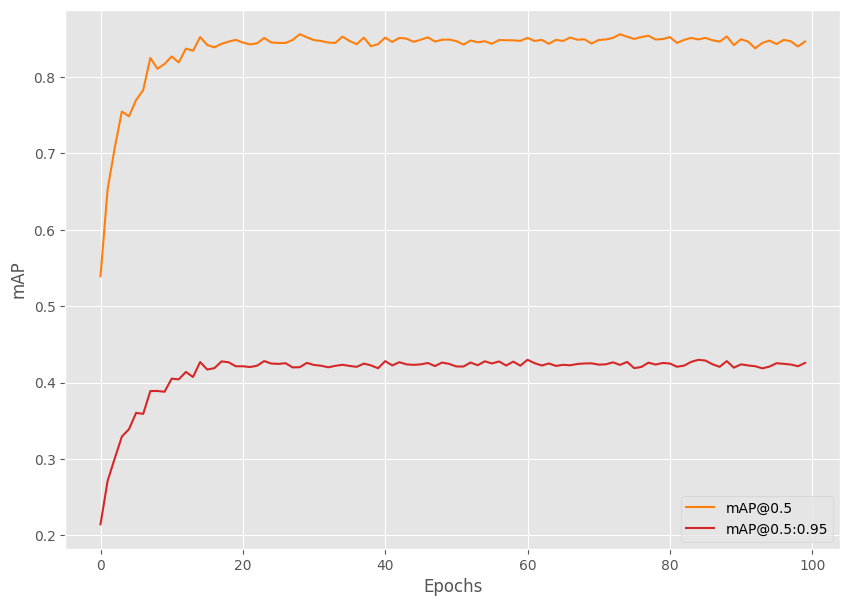

In [14]:
# Initialize a CSV file to store the metrics
csv_file = os.path.join(OUT_DIR, 'training_metrics.csv')
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Validation mAP50', 'Validation mAP50-95', 'Learning Rate'])

# To monitor training loss
train_loss_hist = Averager()
# To store training loss and mAP values.
train_loss_list = []
map_50_list = []
map_list = []

# Ensure the model is in training mode
model.train()

save_best_model = SaveBestModel()

metric = MeanAveragePrecision()

for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)
    
    # Display training loss and validation mAP
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} mAP@0.5: {metric_summary['map_50']*100:.2f}%")   
    print(f"Epoch #{epoch+1} mAP@0.5:0.95: {metric_summary['map']*100:.2f}%")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    # Save the loss and mAP values
    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    # Save metrics to CSV
    current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, train_loss_hist.value, metric_summary['map_50']*100, metric_summary['map']*100, current_lr])

    # Save the best model till now.
    save_best_model(model, float(metric_summary['map']), epoch, 'outputs')

    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)

    # Step the scheduler
    scheduler.step()

print(f"Training complete. Metrics saved to {csv_file}")

## Evaluate on Test Data

In [15]:
model = create_model(num_classes=NUM_CLASSES, weights_path=None)
checkpoint = torch.load("/home/jupyter/ee_tree_counting/Models/RetinaNet/outputs/best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Evaluate on the test dataset
test_dataset = create_valid_dataset("/home/jupyter/ee_tree_counting/Data/GEE Dataset/Dataset XML/test")
test_loader = create_valid_loader(test_dataset, num_workers=NUM_WORKERS)

metric_summary = validate(test_loader, model)
print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

Validating


/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:156: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


  0%|          | 0/1 [00:00<?, ?it/s]

mAP_50: 71.460
mAP_50_95: 35.942


/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
